In [1]:
# from opt_einsum.paths import branch_1
!apt-get update
!apt-get install graphviz -y

!pip install tensorflow
!pip install numpy
!pip install pandas

!pip install keras
!pip install scikit-learn
!pip install matplotlib
!pip install joblib
!pip install pyarrow
!pip install fastparquet
!pip install scipy
!pip install seaborn
!pip install tqdm
!pip install pydot
!pip install tensorflow-io
!pip install tensorflow-addons

Hit:1 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:2 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Reading package lists... Done
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
graphviz is already the newest version (2.42.2-6ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 121 not upgraded.

[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip

[notice] A new release of pip is av

In [2]:
import tensorflow as tf
from tensorflow.keras.layers import (
    Dense, LSTM, MultiHeadAttention, Dropout, BatchNormalization, 
    LayerNormalization, Input, Activation, Lambda, Bidirectional, 
    Add, MaxPooling1D, SpatialDropout1D, GlobalAveragePooling1D,
    GlobalMaxPooling1D, Concatenate, ThresholdedReLU, Average,
    Conv1D, Multiply
)
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.metrics import AUC
from tensorflow.keras.utils import plot_model

# Data processing and analysis
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, r2_score, 
    confusion_matrix, classification_report, roc_auc_score
)

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Additional utilities
import tensorflow_addons as tfa
from scipy import stats
import json
from datetime import datetime
import os
import joblib

folder_name = datetime.now().strftime("%Y-%m-%d_%H-%M")

random_state_value = None

2024-11-27 23:17:43.475455: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-27 23:17:43.475499: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-27 23:17:43.475533: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-27 23:17:43.483362: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/usr/local/lib/python3.11/dist-packages/tensorflow

In [3]:
def get_season(date):
    month = date.month
    day = date.day
    if (month == 12 and day >= 21) or (month <= 3 and day < 20):
        return 'Winter'
    elif (month == 3 and day >= 20) or (month <= 6 and day < 21):
        return 'Spring'
    elif (month == 6 and day >= 21) or (month <= 9 and day < 23):
        return 'Summer'
    elif (month == 9 and day >= 23) or (month <= 12 and day < 21):
        return 'Autumn'
    else:
        return 'Unknown'


def get_time_period(hour):
    if 5 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 17:
        return 'Afternoon'
    elif 17 <= hour < 21:
        return 'Evening'
    else:
        return 'Night'


def add_time_features(df):
    df['datetime'] = pd.to_datetime(df['datetime'])
    df['timestamp'] = df['datetime'].astype(np.int64) // 10 ** 9
    df['year'] = df['datetime'].dt.year
    df['month'] = df['datetime'].dt.month
    df['day'] = df['datetime'].dt.day
    df['hour'] = df['datetime'].dt.hour
    df['minute'] = df['datetime'].dt.minute
    df['hour_sin'] = np.sin(df['hour'] * (2 * np.pi / 24))
    df['hour_cos'] = np.cos(df['hour'] * (2 * np.pi / 24))
    df['day_of_week'] = df['datetime'].dt.dayofweek
    df['day_of_year'] = df['datetime'].dt.dayofyear
    df['week_of_year'] = df['datetime'].dt.isocalendar().week.astype(int)
    df['quarter'] = df['datetime'].dt.quarter
    df['is_month_end'] = df['datetime'].dt.is_month_end.astype(int)
    df['is_quarter_end'] = df['datetime'].dt.is_quarter_end.astype(int)
    df['is_year_end'] = df['datetime'].dt.is_year_end.astype(int)
    df['month_sin'] = np.sin(df['month'] * (2 * np.pi / 12))
    df['month_cos'] = np.cos(df['month'] * (2 * np.pi / 12))
    df['day_of_year_sin'] = np.sin(df['day_of_year'] * (2 * np.pi / 365.25))
    df['day_of_year_cos'] = np.cos(df['day_of_year'] * (2 * np.pi / 365.25))
    df['season'] = df['datetime'].apply(get_season)
    df['time_period'] = df['hour'].apply(get_time_period)
    return df


def add_solar_features(df):
    # Features based only on radiation and other available variables
    df['solar_elevation'] = np.sin(df['day_of_year'] * (2 * np.pi / 365.25)) * np.sin(df['hour'] * (2 * np.pi / 24))

    # Energy-specific features
    df['radiation_clearsky'] = df['solarradiation'] * (100 - df['cloudcover']) / 100

    # Temperature impact on theoretical efficiency
    df['temp_efficiency_factor'] = 1 - 0.004 * (df['temp'] - 25)  # Typical temperature coefficient

    # Combined features
    df['cloud_impact'] = df['cloudcover'] * df['solarradiation']
    df['visibility_radiation'] = df['visibility'] * df['solarradiation']
    df['clear_sky_index'] = (100 - df['cloudcover']) / 100
    df['temp_effect'] = df['temp'] - df['tempmin']

    return df

def add_solar_specific_features(df):
    """
    Aggiunge feature specifiche per la predizione della radiazione solare
    combinando caratteristiche astronomiche e meteorologiche
    """
    # Caratteristiche astronomiche
    df['day_length'] = 12 + 3 * np.sin(2 * np.pi * (df['day_of_year'] - 81) / 365.25)
    df['solar_noon'] = np.abs(12 - df['hour'])
    df['solar_elevation'] = np.sin(2 * np.pi * df['day_of_year'] / 365.25) * np.cos(2 * np.pi * df['solar_noon'] / 24)

    # Angolo solare teorico
    df['solar_angle'] = np.sin(df['hour_sin']) * np.sin(df['day_of_year_sin'])

    # Interazioni con condizioni atmosferiche
    df['cloud_elevation'] = df['cloudcover'] * df['solar_elevation']
    df['visibility_elevation'] = df['visibility'] * df['solar_elevation']
    df['uv_cloud_interaction'] = df['uvindex'] * (100 - df['cloudcover']) / 100

    # Indici di chiarezza e trasmissione
    df['clearness_index'] = (100 - df['cloudcover']) * df['visibility'] / 10000
    df['atmospheric_attenuation'] = (df['pressure'] / 1013.25) * (1 - (df['humidity'] / 100) * 0.6)

    # Radiazione teorica e attenuazione
    df['theoretical_radiation'] = df['solar_angle'].clip(0, 1) * 1000
    df['expected_radiation'] = df['theoretical_radiation'] * df['clearness_index']

    # Rolling features
    df['cloud_rolling_12h'] = df['cloudcover'].rolling(window=12).mean()
    df['temp_rolling_12h'] = df['temp'].rolling(window=12).mean()
    df['uv_rolling_12h'] = df['uvindex'].rolling(window=12).mean()

    # Interazioni temperatura-radiazione
    df['temp_radiation_potential'] = df['temp'] * df['solar_elevation']

    return df

def add_radiation_energy_features(df):
    """Adds specific features based on solarenergy and uvindex"""

    # Solar energy to UV ratio (independent from solarradiation)
    df['energy_uv_ratio'] = df['solarenergy'] / (df['uvindex'] + 1e-6)

    # Time aggregations
    # Moving averages
    windows = [3, 6, 12, 24]  # hours
    for w in windows:
        df[f'energy_rolling_mean_{w}h'] = df['solarenergy'].rolling(window=w).mean()
        df[f'uv_rolling_mean_{w}h'] = df['uvindex'].rolling(window=w).mean()

    # Daily aggregations utilizzando datetime
    df['energy_daily_sum'] = df.groupby(df['datetime'].dt.date)['solarenergy'].transform('sum')
    df['uv_daily_max'] = df.groupby(df['datetime'].dt.date)['uvindex'].transform('max')

    # Changes
    df['energy_change'] = df['solarenergy'].diff()
    df['uv_change'] = df['uvindex'].diff()

    # Lag features
    lags = [1, 2, 3, 6, 12, 24]  # hours
    for lag in lags:
        df[f'energy_lag_{lag}h'] = df['solarenergy'].shift(lag)
        df[f'uv_lag_{lag}h'] = df['uvindex'].shift(lag)

    # Peak indicators
    df['is_energy_peak'] = (df['solarenergy'] > df['energy_rolling_mean_6h'] * 1.2).astype(int)
    df['is_uv_peak'] = (df['uvindex'] > df['uv_rolling_mean_6h'] * 1.2).astype(int)

    # Aggiungiamo alcune metriche di volatilità
    df['energy_volatility'] = df['energy_change'].rolling(window=24).std()
    df['uv_volatility'] = df['uv_change'].rolling(window=24).std()

    # Indice di intensità solare composito
    df['solar_intensity_index'] = (df['solarenergy'] * df['uvindex']) / (df['cloudcover'] + 1e-6)

    # Interazioni
    df['uv_cloud_interaction'] = df['uvindex'] * (100 - df['cloudcover']) / 100
    df['energy_temp_interaction'] = df['solarenergy'] * df['temp']

    return df

def add_atmospheric_features(df):
    # Indice di Massa d'Aria (Air Mass Index)
    # Rappresenta il percorso ottico relativo dei raggi solari attraverso l'atmosfera
    df['air_mass_index'] = 1 / (np.cos(np.radians(90 - df['solar_elevation'])) + 0.50572 *
                                (96.07995 - (90 - df['solar_elevation']))**-1.6364)

    # Indice di Stabilità Atmosferica
    # Combina temperatura, umidità e pressione
    df['atmospheric_stability'] = (df['temp'] * (100 - df['humidity'])) / df['pressure']

    # Vapor Pressure Deficit (VPD)
    # Importante per la radiazione diffusa
    df['saturation_vapor_pressure'] = 0.6108 * np.exp(17.27 * df['temp'] / (df['temp'] + 237.3))
    df['actual_vapor_pressure'] = df['saturation_vapor_pressure'] * (df['humidity'] / 100)
    df['vapor_pressure_deficit'] = df['saturation_vapor_pressure'] - df['actual_vapor_pressure']

    return df

def add_diffusion_features(df):
    # Indice di Diffusione
    df['diffusion_index'] = (df['cloudcover'] * df['humidity']) / 10000

    # Radiazione Diretta vs Diffusa
    df['direct_radiation'] = df['solarradiation'] * (1 - df['diffusion_index'])
    df['diffuse_radiation'] = df['solarradiation'] * df['diffusion_index']

    # Fattore di Trasparenza Atmosferica
    df['atmospheric_transmittance'] = (1 - df['cloudcover']/100) * (df['visibility']/10) * (1 - df['humidity']/200)

    return df

def calculate_trend(x):
    try:
        return np.polyfit(np.arange(len(x)), x, 1)[0]
    except:
        return np.nan

def add_persistence_features(df):
    # Create a copy to avoid modifying the original dataframe
    df = df.copy()

    # Calculate trends more efficiently
    windows = [3, 6, 12, 24]
    for w in windows:
        # Use numba or vectorized operations if possible
        df[f'radiation_trend_{w}h'] = df['solarradiation'].rolling(
            window=w,
            min_periods=w
        ).apply(calculate_trend, raw=True)

    # Optimize volatility calculation by doing it in one pass
    rolling_24 = df['solarradiation'].rolling(24, min_periods=1)
    df['radiation_volatility'] = rolling_24.std() / rolling_24.mean().clip(lower=1e-10)

    return df

def add_weather_pattern_features(df):
    # Pattern giornalieri
    df['clear_sky_duration'] = df.groupby(df['datetime'].dt.date)['cloudcover'].transform(
        lambda x: (x < 30).sum()
    )

    # Stabilità delle condizioni
    for col in ['temp', 'humidity', 'cloudcover']:
        df[f'{col}_stability'] = df[col].rolling(12).std() / df[col].rolling(12).mean()

    # Indice di Variabilità Meteorologica
    df['weather_variability_index'] = (df['temp_stability'] +
                                       df['humidity_stability'] +
                                       df['cloudcover_stability']) / 3

    return df

def add_efficiency_features(df):
    # Perdite per temperatura
    df['temp_losses'] = 0.004 * (df['temp'] - 25).clip(lower=0)  # 0.4% per grado sopra 25°C

    # Perdite per polvere/sporco (stima basata su umidità e pressione)
    df['soiling_loss_factor'] = 0.002 * (df['humidity']/100) * (df['pressure']/1013.25)

    # Efficienza complessiva stimata
    df['estimated_efficiency'] = (1 - df['temp_losses']) * (1 - df['soiling_loss_factor']) * \
                                 df['atmospheric_transmittance']

    # Potenziale di produzione
    df['production_potential'] = df['solarradiation'] * df['estimated_efficiency']

    return df

def add_advanced_seasonal_features(df):
    # Differenza dalla durata media del giorno
    avg_day_length = 12
    df['day_length_deviation'] = df['day_length'] - avg_day_length

    # Intensità stagionale
    df['seasonal_intensity'] = np.sin(2 * np.pi * (df['day_of_year'] - 172) / 365.25)

    # Indice di Stagionalità
    df['seasonality_index'] = df['seasonal_intensity'] * df['solar_elevation']

    # Correzione per alba/tramonto
    df['daylight_correction'] = np.where(
        (df['hour'] >= df['day_length']) | (df['hour'] <= 24-df['day_length']),
        0,
        1
    )

    return df

def add_basic_interactions(df):
    """
    Aggiunge le interazioni base tra variabili meteorologiche
    """
    # Feature esistenti originali
    df['temp_humidity'] = df['temp'] * df['humidity']
    df['temp_cloudcover'] = df['temp'] * df['cloudcover']
    df['visibility_cloudcover'] = df['visibility'] * df['cloudcover']
    df['temp_humidity_interaction'] = df['temp'] * df['humidity'] / 100

    # Clear sky e trasparenza atmosferica
    df['clear_sky_factor'] = (100 - df['cloudcover']) / 100
    df['atmospheric_transparency'] = (100 - df['cloudcover']) * (df['visibility'] / 10)

    return df

def add_rolling_and_lag_features(df):
    """
    Aggiunge feature rolling e lag
    """
    # Rolling means esistenti
    df['temp_rolling_mean_6h'] = df['temp'].rolling(window=6).mean()
    df['cloudcover_rolling_mean_6h'] = df['cloudcover'].rolling(window=6).mean()

    # Lag features esistenti
    df['temp_1h_lag'] = df['temp'].shift(1)
    df['cloudcover_1h_lag'] = df['cloudcover'].shift(1)
    df['humidity_1h_lag'] = df['humidity'].shift(1)

    return df

def add_condition_indicators(df):
    """
    Aggiunge indicatori di condizioni particolari
    """
    # Extreme conditions indicator esistente
    df['extreme_conditions'] = ((df['temp'] > df['temp'].quantile(0.75)) &
                                (df['humidity'] < df['humidity'].quantile(0.25))).astype(int)

    return df

def add_physics_based_conversion_features(df):
    """
    Aggiunge feature specifiche per la conversione tra radiazione ed energia
    """
    # Conversione da kWh a MJ/m²/h (1 W = 1 J/s = 0.0036 MJ/h)
    df['radiation_to_energy'] = df['solarradiation'] * 0.0036

    # Efficienza di conversione reale vs teorica
    df['conversion_efficiency_ratio'] = df['solarenergy'] / df['radiation_to_energy'].clip(lower=1e-6)

    # Energia accumulata nel tempo (integrazione)
    df['energy_integral'] = df['radiation_to_energy'].rolling(window=24).sum()

    # Differenza tra energia teorica e reale
    df['energy_conversion_gap'] = df['radiation_to_energy'] - df['solarenergy']

    # Indice di performance del sistema
    df['system_performance_ratio'] = df['solarenergy'] / df['radiation_to_energy'].clip(lower=1e-6)

    return df

def add_advanced_features(df):
    """
    Add all advanced features to the DataFrame
    """
    # Feature esistenti di base
    # 1. Feature temporali di base
    df = add_time_features(df)

    # 2. Feature solari e meteorologiche
    df = add_solar_features(df)
    df = add_solar_specific_features(df)
    df = add_radiation_energy_features(df)

    # 3. Feature atmosferiche e di diffusione
    df = add_atmospheric_features(df)
    df = add_diffusion_features(df)

    # 4. Feature di persistenza e pattern
    df = add_persistence_features(df)
    df = add_weather_pattern_features(df)

    # 5. Feature di efficienza e stagionalità
    df = add_efficiency_features(df)
    df = add_advanced_seasonal_features(df)

    # 6. Interazioni e feature derivate
    df = add_basic_interactions(df)
    df = add_rolling_and_lag_features(df)
    df = add_condition_indicators(df)

    # 7. Nuove feature di conversione fisica
    df = add_physics_based_conversion_features(df)

    # 8. One-hot encoding delle feature categoriche
    df = pd.get_dummies(df, columns=['season', 'time_period'])

    return df


def prepare_advanced_data(df):
    """
    Prepare data for advanced modeling with proper datetime handling
    """
    # Assicuriamoci che abbiamo una copia del DataFrame
    df = df.copy()

    # Apply feature engineering functions
    df = add_advanced_features(df)

    #all_columns = list(df.columns)
    #print(all_columns)

    features = {
        # Primary Features (strong direct correlation)
        'primary_features': [
            'uvindex',
            'cloudcover',
            'visibility',
            'temp',
            'pressure',
            'humidity',
            'solarradiation'
        ],

        # Astronomical and Temporal Features
        'astronomical_features': [
            'solar_elevation',
            'solar_angle',
            'day_length',
            'hour_sin',
            'hour_cos',
            'day_of_year_sin',
            'day_of_year_cos',
            'month_sin',
            'month_cos',
            'solar_noon',
            'daylight_correction'
        ],

        # Key Indices and Interactions
        'key_interactions': [
            'clear_sky_index',
            'atmospheric_attenuation',
            'theoretical_radiation',
            'expected_radiation',
            'cloud_elevation',
            'visibility_elevation',
            'uv_cloud_interaction',
            'temp_radiation_potential',
            'air_mass_index',
            'atmospheric_stability',
            'vapor_pressure_deficit',
            'diffusion_index',
            'atmospheric_transmittance',
            'temp_humidity_interaction',
            'clear_sky_factor'
        ],

        # Rolling Features (temporal trends)
        'rolling_features': [
            'cloud_rolling_12h',
            'temp_rolling_12h',
            'uv_rolling_12h',
            'cloudcover_rolling_mean_6h',
            'temp_rolling_mean_6h',
            'energy_rolling_mean_6h',
            'uv_rolling_mean_6h',
            'energy_volatility',
            'uv_volatility'
        ],

        # Lag Features
        'lag_features': [
            'temp_1h_lag',
            'cloudcover_1h_lag',
            'humidity_1h_lag',
            'energy_lag_1h',
            'uv_lag_1h'
        ],

        # Efficiency and Performance Features
        'efficiency_features': [
            'temp_losses',
            'soiling_loss_factor',
            'estimated_efficiency',
            'production_potential',
            'system_performance_ratio',
            'conversion_efficiency_ratio'
        ],

        # Weather Pattern Features
        'weather_pattern_features': [
            'clear_sky_duration',
            'weather_variability_index',
            'temp_stability',
            'humidity_stability',
            'cloudcover_stability'
        ],

        # Categorical Features
        'categorical_features': [
            'season_Spring',
            'season_Summer',
            'season_Autumn',
            'season_Winter',
            'time_period_Morning',
            'time_period_Afternoon',
            'time_period_Evening',
            'time_period_Night'
        ]
    }

    final_features = [feature for group in features.values() for feature in group]

    if not isinstance(df.index, pd.DatetimeIndex):
        if 'datetime' in df.columns:
            df['datetime'] = pd.to_datetime(df['datetime'])
            df.set_index('datetime', inplace=True)
        else:
            raise ValueError("No datetime column or index found in DataFrame")

    # Ordiniamo il DataFrame per datetime
    df = df.sort_index()

    # Handle missing values
    target_variables = ['solarradiation', 'solarenergy', 'uvindex']
    for column in final_features + target_variables:
        if column in df.columns:
            if isinstance(df.index, pd.DatetimeIndex):
                df[column] = df[column].interpolate(method='time')
            else:
                df[column] = df[column].interpolate(method='linear')

    df.fillna(0, inplace=True)

    # Temporal split
    data_after_2010 = df[df['year'] >= 2010].copy()
    data_before_2010 = df[df['year'] < 2010].copy()

    X = data_after_2010[final_features]
    y = data_after_2010['solarenergy']
    X_to_predict = data_before_2010[final_features]

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.13, random_state=random_state_value, shuffle=False
    )

    # Scaling
    scaler_X = RobustScaler()
    X_train_scaled = scaler_X.fit_transform(X_train)
    X_test_scaled = scaler_X.transform(X_test)
    X_to_predict_scaled = scaler_X.transform(X_to_predict)

    scaler_y = RobustScaler()
    y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
    y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

    # Print info about selected features
    print("\nSelected features:")
    print(f"Number of features: {len(final_features)}")
    print("Features list:", final_features)

    return X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled, scaler_X, scaler_y, final_features, X_to_predict_scaled


def create_sequence_data(X, sequence_length=24):
    """
    Converts data into sequences for LSTM input
    sequence_length represents how many previous hours to consider
    """
    sequences = []
    for i in range(len(X) - sequence_length + 1):
        sequences.append(X[i:i + sequence_length])
    return np.array(sequences)


def prepare_hybrid_data(df):
    X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled, scaler_X, scaler_y, features, X_to_predict_scaled = prepare_advanced_data(df)

    # Convert data into sequences
    sequence_length = 24  # 24 hours of historical data

    X_train_seq = create_sequence_data(X_train_scaled, sequence_length)
    X_test_seq = create_sequence_data(X_test_scaled, sequence_length)

    # Adjust y by removing the first (sequence_length-1) elements
    y_train = y_train_scaled[sequence_length - 1:]
    y_test = y_test_scaled[sequence_length - 1:]

    X_to_predict_seq = create_sequence_data(X_to_predict_scaled, sequence_length)

    return X_train_seq, X_test_seq, y_train, y_test, scaler_X, scaler_y, features, X_to_predict_seq

In [4]:
def create_solarenergy_model(input_shape, folder_name, l2_lambda=0.005, min_output=0, max_output=4.0):
    from tensorflow import keras
    from keras.models import Model
    from keras.layers import (
        Input, Dense, Conv1D, BatchNormalization, Dropout, 
        MultiHeadAttention, LayerNormalization, Lambda,
        Concatenate, Activation, Bidirectional, LSTM, Add
    )
    from keras.regularizers import l2
    from keras.optimizers import AdamW
    import tensorflow as tf
    import numpy as np
    import tensorflow_addons as tfa
    from tensorflow.keras.optimizers.schedules import CosineDecayRestarts
    
    # Input layer
    inputs = Input(shape=input_shape)
    
    # Feature groups definition
    feature_dims = {
        'solar': [6, 7, 8, 9, 16, 18, 19, 20, 21],
        'weather': [0, 1, 2, 3, 4, 5],
        'temporal': [10, 11, 12, 13, 14, 15],
        'derived': [22, 23, 24, 25, 26, 27, 28, 29, 30, 31],
        'rolling': [33, 34, 35, 36, 37, 38, 39],
        'lag': [40, 41, 42, 43, 44],
        'performance': [45, 46, 47, 48, 49, 50]
    }
    
    # Feature extraction
    feature_tensors = {}
    for name, indices in feature_dims.items():
        valid_indices = [i for i in indices if i < input_shape[-1]]
        if valid_indices:
            feature_tensors[name] = Lambda(
                lambda x, idx=valid_indices: tf.gather(x, idx, axis=-1)
            )(inputs)
    
    # Feature processing with residual connections
    def process_feature_group(tensor, units, name):
        x = Conv1D(units, kernel_size=3, padding='same', activation='swish',
                  kernel_regularizer=l2(l2_lambda))(tensor)
        x = BatchNormalization()(x)
        x = Dropout(0.2)(x)
        
        residual = Conv1D(units, kernel_size=1, padding='same')(tensor)
        x = Add()([x, residual])
        x = LayerNormalization()(x)
        
        return x
    
    # Process each feature group
    processed_features = {}
    for name, tensor in feature_tensors.items():
        units = 64 if name == 'solar' else 32 if name == 'weather' else 16
        processed_features[name] = process_feature_group(tensor, units, name)
    
    # Enhanced attention mechanism
    def attention_block(x, num_heads=4):
        attention_output = MultiHeadAttention(
            num_heads=num_heads, 
            key_dim=x.shape[-1] // num_heads
        )(x, x)
        x = LayerNormalization()(x + attention_output)
        
        ffn = Dense(x.shape[-1] * 2, activation='swish')(x)
        ffn = Dropout(0.1)(ffn)
        ffn = Dense(x.shape[-1])(ffn)
        
        return LayerNormalization()(x + ffn)
    
    # Merge primary features with attention
    primary_features = [
        processed_features['solar'],
        processed_features['weather'],
        processed_features['performance']
    ]
    primary_context = Concatenate(axis=-1)(primary_features)
    primary_context = attention_block(primary_context)
    
    # Merge secondary features
    secondary_features = [
        processed_features[name] for name in ['temporal', 'rolling', 'lag']
        if name in processed_features
    ]
    if secondary_features:
        secondary_context = Concatenate(axis=-1)(secondary_features)
        secondary_context = attention_block(secondary_context)
    else:
        secondary_context = primary_context
    
    # Final feature merge
    combined = Concatenate(axis=-1)([
        primary_context, 
        secondary_context,
        processed_features['derived']
    ])
    
    # Sequential processing with residual LSTM
    def residual_lstm_block(x, units):
        lstm_out = Bidirectional(LSTM(units, return_sequences=True))(x)
        residual = Conv1D(units * 2, kernel_size=1, padding='same')(x)
        x = Add()([lstm_out, residual])
        x = LayerNormalization()(x)
        return x
    
    x = residual_lstm_block(combined, 128)
    x = residual_lstm_block(x, 64)
    x = Bidirectional(LSTM(64))(x)
    x = Dropout(0.2)(x)
    
    # Classification branch
    class_x = Dense(128, activation='swish', kernel_regularizer=l2(l2_lambda))(x)
    class_x = BatchNormalization()(class_x)
    class_x = Dropout(0.2)(class_x)
    class_x = Dense(64, activation='swish', kernel_regularizer=l2(l2_lambda))(class_x)
    class_output = Dense(1, activation='sigmoid', name='classification_output')(class_x)
    
    # Enhanced regression branch with multiple pathways
    def create_regression_pathway(x, name):
        x = Dense(128, activation='swish', kernel_regularizer=l2(l2_lambda))(x)
        x = BatchNormalization()(x)
        x = Dropout(0.2)(x)
        
        residual = x
        x = Dense(128, activation='swish', kernel_regularizer=l2(l2_lambda))(x)
        x = BatchNormalization()(x)
        x = Dense(128, activation='swish', kernel_regularizer=l2(l2_lambda))(x)
        x = Add()([x, residual])
        
        x = Dense(64, activation='swish', kernel_regularizer=l2(l2_lambda))(x)
        return Dense(1, name=f'{name}_output')(x)
    
    # Create specialized regression pathways
    low_range = create_regression_pathway(x, 'low_range')
    mid_range = create_regression_pathway(x, 'mid_range')
    high_range = create_regression_pathway(x, 'high_range')
    
    # Create context vector for attention
    context = Dense(64, activation='swish')(x)
    
    # Calculate attention scores
    attention_scores = Dense(3, activation='softmax')(context)
    
    # Combine predictions using attention weights
    reg_output = Lambda(
        lambda x: x[0][:, 0:1] * x[1] + x[0][:, 1:2] * x[2] + x[0][:, 2:3] * x[3],
        name='regression_output'
    )([attention_scores, low_range, mid_range, high_range])

    # Final output processing remains the same...
    final_x = Dense(256, activation='swish', kernel_regularizer=l2(l2_lambda))(x)
    final_x = BatchNormalization()(final_x)
    final_x = Dropout(0.2)(final_x)
    
    residual = final_x
    final_x = Dense(256, activation='swish', kernel_regularizer=l2(l2_lambda))(final_x)
    final_x = BatchNormalization()(final_x)
    final_x = Dense(256, activation='swish', kernel_regularizer=l2(l2_lambda))(final_x)
    final_x = Add()([final_x, residual])
    
    final_x = Dense(128, activation='swish', kernel_regularizer=l2(l2_lambda))(final_x)
    final_x = Dense(1)(final_x)
    final_output = Lambda(
        lambda x: tf.clip_by_value(x, min_output, max_output),
        name='final_output'
    )(final_x)
    
    # Build model with all outputs
    model = Model(
        inputs=inputs,
        outputs=[class_output, reg_output, final_output]
    )
    
    # Enhanced loss functions
    def enhanced_regression_loss(y_true, y_pred):
        mae = tf.abs(y_true - y_pred)
        mse = tf.square(y_true - y_pred)
        
        value_ranges = tf.cast(y_true > 2.0, tf.float32) * 1.5 + \
                      tf.cast(tf.logical_and(y_true <= 2.0, y_true > 1.0), tf.float32) * 1.2 + \
                      tf.cast(y_true <= 1.0, tf.float32)
        
        weighted_loss = (0.5 * mae + 0.5 * mse) * value_ranges
        return tf.reduce_mean(weighted_loss)
    
    def final_loss(y_true, y_pred):
        y_true = tf.clip_by_value(y_true, min_output, max_output)
        mae = tf.reduce_mean(tf.abs(y_true - y_pred))
        mse = tf.reduce_mean(tf.square(y_true - y_pred))
        return 0.5 * mae + 0.5 * mse
    
    # Learning rate schedule
    clr = CosineDecayRestarts(
        initial_learning_rate=2e-4,
        first_decay_steps=1000,
        t_mul=2.0,
        m_mul=0.9,
        alpha=1e-7
    )
    
    # Optimizer
    optimizer = AdamW(
        learning_rate=clr,
        weight_decay=0.01,
        clipnorm=1.0
    )
    
    # Compile model
    model.compile(
        optimizer=optimizer,
        loss={
            'classification_output': 'binary_crossentropy',
            'regression_output': enhanced_regression_loss,
            'final_output': final_loss
        },
        loss_weights={
            'classification_output': 0.2,
            'regression_output': 0.4,
            'final_output': 0.4
        }
    )

    # Plot model architecture
    try:
        plot_model(
            model,
            to_file=f'{folder_name}_model_architecture.png',
            show_shapes=True,
            show_layer_names=True,
            dpi=150,
            show_layer_activations=True
        )
    except Exception as e:
        print(f"Warning: Could not plot model architecture: {e}")

    return model


def evaluate_solarenergy_predictions(y_true, y_pred, hour=None, folder_name=None):
    """
    Comprehensive evaluation of solar energy predictions with detailed analysis and visualizations.

    Parameters:
    -----------
    y_true : array-like
        Actual solar energy values (kWh)
    y_pred : array-like
        Predicted solar energy values (kWh)
    hour : array-like, optional
        Array of hours corresponding to predictions, for temporal analysis
    folder_name : str, optional
        Directory to save analysis plots

    Returns:
    --------
    dict
        Dictionary containing all calculated metrics
    """

    # Data preparation
    y_true = np.array(y_true).ravel()
    y_pred = np.array(y_pred).ravel()
    errors = y_pred - y_true

    # Basic metrics calculation
    mae_raw = mean_absolute_error(y_true, y_pred)
    rmse_raw = np.sqrt(mean_squared_error(y_true, y_pred))
    r2_raw = r2_score(y_true, y_pred)

    # Corrected MAPE calculation
    mask = y_true > 10  # Consider only values above 10 kWh
    if np.any(mask):
        mape = np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100
    else:
        mape = np.nan

    # Corrected error margin accuracy
    within_5_percent = np.mean(np.abs(errors) <= 5) * 100  # Within 5 kWh
    within_10_percent = np.mean(np.abs(errors) <= 10) * 100  # Within 10 kWh
    within_20_percent = np.mean(np.abs(errors) <= 20) * 100  # Within 20 kWh

    # Energy level classification
    def get_energy_level(value):
        if value <= 0.5:
            return 'Very Low'
        elif value <= 2.0:
            return 'Low'
        elif value <= 4.0:
            return 'Moderate'
        elif value <= 6.0:
            return 'High'
        elif value <= 8.0:
            return 'Very High'
        else:
            return 'Extreme'

    # Calculate energy levels
    y_true_levels = [get_energy_level(v) for v in y_true]
    y_pred_levels = [get_energy_level(v) for v in y_pred]
    level_accuracy = np.mean([t == p for t, p in zip(y_true_levels, y_pred_levels)])

    unique_levels = sorted(list(set(y_true_levels + y_pred_levels)))

    # Print main metrics
    print("\nSolar Energy Prediction Metrics:")
    print("\nAbsolute Metrics:")
    print(f"MAE: {mae_raw:.2f} kWh")
    print(f"RMSE: {rmse_raw:.2f} kWh")
    print(f"R² Score: {r2_raw:.3f}")
    print(f"MAPE: {mape:.2f}%" if not np.isnan(mape) else "MAPE: N/A (insufficient data)")

    print("\nAccuracy Metrics:")
    print(f"Within ±5 kWh: {within_5_percent:.1f}%")
    print(f"Within ±10 kWh: {within_10_percent:.1f}%")
    print(f"Within ±20 kWh: {within_20_percent:.1f}%")

    print("\nLevel Accuracy:")
    print(f"Level Accuracy: {level_accuracy * 100:.1f}%")

    # Confusion matrix for energy levels
    cm = confusion_matrix(y_true_levels, y_pred_levels, labels=unique_levels)
    print("\nConfusion Matrix for Energy Levels:")
    cm_df = pd.DataFrame(
        cm,
        columns=unique_levels,
        index=unique_levels
    )
    print(cm_df)

    # Time period analysis
    if hour is not None:
        day_periods = {
            'Morning (5-11)': (5, 11),
            'Noon (11-13)': (11, 13),
            'Afternoon (13-17)': (13, 17),
            'Evening (17-21)': (17, 21),
            'Night (21-5)': (21, 5)
        }

        print("\nAnalysis by Time Period:")
        for period, (start, end) in day_periods.items():
            if start < end:
                mask = (hour >= start) & (hour < end)
            else:
                mask = (hour >= start) | (hour < end)

            if np.any(mask):
                period_mae = mean_absolute_error(y_true[mask], y_pred[mask])

                # Corrected period MAPE calculation
                period_mask = mask & (y_true > 10)
                if np.any(period_mask):
                    period_mape = np.mean(np.abs((y_true[period_mask] - y_pred[period_mask]) / y_true[period_mask])) * 100
                    print(f"\n{period}:")
                    print(f"MAE: {period_mae:.2f} kWh")
                    print(f"MAPE: {period_mape:.2f}%")
                else:
                    print(f"\n{period}:")
                    print(f"MAE: {period_mae:.2f} kWh")
                    print("MAPE: N/A (insufficient data)")

    # Visualizations
    if folder_name is not None:
        try:
            # Figure 1: Main analysis plots
            plt.figure(figsize=(20, 15))

            # Plot 1: Scatter plot of actual vs predicted values
            plt.subplot(3, 2, 1)
            plt.scatter(y_true, y_pred, alpha=0.5)
            plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
            plt.xlabel('Actual Energy (kWh)')
            plt.ylabel('Predicted Energy (kWh)')
            plt.title('Actual vs Predicted Values')
            plt.grid(True)

            # Plot 2: Absolute error distribution
            plt.subplot(3, 2, 2)
            plt.hist(errors, bins=50, alpha=0.7)
            plt.xlabel('Prediction Error (kWh)')
            plt.ylabel('Frequency')
            plt.title('Error Distribution')
            plt.grid(True)

            # Plot 3: Percentage error distribution (only for values > 0.5 kWh)
            plt.subplot(3, 2, 3)
            mask = y_true > 0.5
            if np.any(mask):
                percentage_errors = ((y_pred[mask] - y_true[mask]) / y_true[mask]) * 100
                plt.hist(np.clip(percentage_errors, -100, 100), bins=50, alpha=0.7)
                plt.xlabel('Percentage Error (%)')
                plt.ylabel('Frequency')
                plt.title('Percentage Error Distribution (for values > 0.5 kWh)')
                plt.grid(True)

            # Plot 4: Errors vs actual values
            plt.subplot(3, 2, 4)
            plt.scatter(y_true, errors, alpha=0.5)
            plt.axhline(y=0, color='r', linestyle='--')
            plt.xlabel('Actual Energy (kWh)')
            plt.ylabel('Error (kWh)')
            plt.title('Errors vs Actual Values')
            plt.grid(True)

            # Plot 5: Error boxplot by Energy level
            plt.subplot(3, 2, 5)
            sns.boxplot(x=[get_energy_level(v) for v in y_true], y=errors)
            plt.xticks(rotation=45)
            plt.xlabel('Energy Level')
            plt.ylabel('Error (kWh)')
            plt.title('Error Distribution by Level')

            # Plot 6: Confusion matrix heatmap
            plt.subplot(3, 2, 6)
            sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
            plt.title('Confusion Matrix')
            plt.xticks(rotation=45)
            plt.yticks(rotation=45)

            plt.tight_layout()
            filename = f'{folder_name}_energy_analysis.png'
            plt.savefig(filename, dpi=300, bbox_inches='tight')
            print(f"\nPlot saved as: {filename}")
            plt.close()

        except Exception as e:
            print(f"\nError saving plots: {str(e)}")

    # Additional error statistics
    print("\nError Statistics:")
    print(f"Mean error: {np.mean(errors):.3f}")
    print(f"Error standard deviation: {np.std(errors):.3f}")
    print(f"Median error: {np.median(errors):.3f}")
    print(f"95th percentile absolute error: {np.percentile(np.abs(errors), 95):.3f}")

    # Return structured metrics
    metrics = {
        'absolute': {
            'mae': mae_raw,
            'rmse': rmse_raw,
            'r2': r2_raw,
            'mape': float(mape) if not np.isnan(mape) else None
        },
        'accuracy': {
            'within_5_wm2': float(within_5_percent),
            'within_10_wm2': float(within_10_percent),
            'within_20_wm2': float(within_20_percent)
        },
        'categorical': {
            'level_accuracy': float(level_accuracy)
        },
        'error_stats': {
            'mean': float(np.mean(errors)),
            'std': float(np.std(errors)),
            'median': float(np.median(errors)),
            'p95_abs': float(np.percentile(np.abs(errors), 95))
        }
    }

    return metrics


def plot_training_history(history, folder_name=None):
    """
    Visualize and save training history for the hybrid model
    """
    plt.figure(figsize=(15, 10))

    # Loss plots
    plt.subplot(2, 2, 1)
    plt.plot(history.history['classification_output_loss'], label='Class Loss')
    plt.plot(history.history['regression_output_loss'], label='Reg Loss')
    plt.plot(history.history['final_output_loss'], label='Final Loss')
    plt.plot(history.history['val_classification_output_loss'], label='Val Class Loss')
    plt.plot(history.history['val_regression_output_loss'], label='Val Reg Loss')
    plt.plot(history.history['val_final_output_loss'], label='Val Final Loss')
    plt.title('Model Losses')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Classification metrics
    plt.subplot(2, 2, 2)
    plt.plot(history.history['classification_output_accuracy'], label='Class Acc')
    plt.plot(history.history['val_classification_output_accuracy'], label='Val Class Acc')
    plt.plot(history.history['classification_output_auc'], label='Class AUC')
    plt.plot(history.history['val_classification_output_auc'], label='Val Class AUC')
    plt.title('Classification Metrics')
    plt.xlabel('Epoch')
    plt.ylabel('Metric Value')
    plt.legend()
    plt.grid(True)

    # Regression metrics
    plt.subplot(2, 2, 3)
    plt.plot(history.history['regression_output_mae'], label='Reg MAE')
    plt.plot(history.history['val_regression_output_mae'], label='Val Reg MAE')
    plt.title('Regression MAE')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.legend()
    plt.grid(True)

    # Final output metrics
    plt.subplot(2, 2, 4)
    plt.plot(history.history['final_output_mae'], label='Final MAE')
    plt.plot(history.history['val_final_output_mae'], label='Val Final MAE')
    plt.title('Final Output MAE')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()

    if folder_name is not None:
        filename = f'{folder_name}_training_history.png'
        plt.savefig(filename, dpi=300, bbox_inches='tight')
        print(f"\nTraining history plot saved as: {filename}")

        # Save history to JSON
        history_dict = history.history
        json_filename = f'{folder_name}_training_history.json'
        with open(json_filename, 'w') as f:
            json.dump(history_dict, f)
        print(f"Training history saved as: {json_filename}")

    plt.show()

def calculate_metrics(y_true, y_class, y_reg, y_final, min_output, max_output):
    """
    Calculates comprehensive metrics for the solar energy prediction model.
    
    Parameters:
    -----------
    y_true : array-like
        Ground truth values
    y_class : array-like
        Classification predictions (probability of non-zero values)
    y_reg : array-like
        Regression predictions (unrestricted values)
    y_final : array-like
        Final clipped predictions
    min_output : float
        Minimum allowed output value
    max_output : float
        Maximum allowed output value
        
    Returns:
    --------
    dict
        Dictionary containing all calculated metrics
    """
    from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
    
    # Ensure proper array formatting and dimensionality
    y_true = np.array(y_true).flatten()
    y_class = np.array(y_class).flatten()
    y_reg = np.array(y_reg).flatten()
    y_final = np.array(y_final).flatten()
    
    # Validate input dimensions
    assert len(y_true) == len(y_class) == len(y_reg) == len(y_final), \
        "All input arrays must have the same length"
    
    # Classification metrics with error handling
    print("\nClassification Metrics:")
    try:
        y_true_binary = (y_true > 0).astype(int)
        y_pred_binary = (y_class > 0.5).astype(int)
        
        accuracy = np.mean((y_class > 0.5) == (y_true > 0)) * 100
        auc_roc = roc_auc_score(y_true > 0, y_class)
        print(f"Accuracy: {accuracy:.2f}%")
        print(f"AUC-ROC: {auc_roc:.4f}")
        
        print("\nConfusion Matrix:")
        conf_matrix = confusion_matrix(y_true_binary, y_pred_binary)
        print(conf_matrix)
        
        print("\nClassification Report:")
        class_report = classification_report(
            y_true_binary, 
            y_pred_binary,
            target_names=['Zero', 'Non-Zero'],
            digits=4
        )
        print(class_report)
    except Exception as e:
        print(f"Error in classification metrics calculation: {str(e)}")
    
    # Regression metrics with error handling
    print("\nRegression Metrics (non-zero values):")
    mask_nonzero = y_true > 0
    if np.any(mask_nonzero):
        try:
            y_true_nonzero = y_true[mask_nonzero]
            y_reg_nonzero = y_reg[mask_nonzero]
            
            # Range validation
            out_of_range = np.sum(
                (y_reg_nonzero < min_output) | 
                (y_reg_nonzero > max_output)
            )
            
            # Error metrics with numerical stability
            epsilon = 1e-7
            diff = np.abs((y_true_nonzero - y_reg_nonzero) / 
                         (y_true_nonzero + epsilon))
            diff = np.clip(diff, 0, 1)
            
            # Calculate metrics
            mape = np.mean(diff) * 100
            within_10_percent = np.mean(diff <= 0.10) * 100
            mae = np.mean(np.abs(y_true_nonzero - y_reg_nonzero))
            rmse = np.sqrt(np.mean(np.square(y_true_nonzero - y_reg_nonzero)))
            
            print(f"Out of range: {out_of_range} predictions")
            print(f"MAPE: {mape:.2f}%")
            print(f"Within ±10%: {within_10_percent:.2f}%")
            print(f"MAE: {mae:.2f}")
            print(f"RMSE: {rmse:.2f}")
        except Exception as e:
            print(f"Error in regression metrics calculation: {str(e)}")
    else:
        print("No non-zero values in this batch")
    
    # Final output metrics with error handling
    print("\nFinal Combined Output Metrics:")
    try:
        # Ensure outputs are within bounds
        out_of_range = np.sum((y_final < min_output) | (y_final > max_output))
        
        # Calculate metrics with numerical stability
        epsilon = 1e-7
        diff = np.abs((y_true - y_final) / (y_true + epsilon))
        diff = np.clip(diff, 0, 1)
        
        mape = np.mean(diff) * 100
        within_2_percent = np.mean(diff <= 0.02) * 100
        within_5_percent = np.mean(diff <= 0.05) * 100
        within_10_percent = np.mean(diff <= 0.10) * 100
        within_20_percent = np.mean(diff <= 0.20) * 100
        mae = np.mean(np.abs(y_true - y_final))
        rmse = np.sqrt(np.mean(np.square(y_true - y_final)))
        
        print(f"Out of range: {out_of_range} predictions")
        print(f"MAPE: {mape:.2f}%")
        print(f"Within ±2%: {within_2_percent:.2f}%")
        print(f"Within ±5%: {within_5_percent:.2f}%")
        print(f"Within ±10%: {within_10_percent:.2f}%")
        print(f"Within ±20%: {within_20_percent:.2f}%")
        print(f"MAE: {mae:.2f}")
        print(f"RMSE: {rmse:.2f}")
    except Exception as e:
        print(f"Error in final output metrics calculation: {str(e)}")

def train_hybrid_model(model, X_train, y_train, X_test, y_test, epochs=100, batch_size=32, folder_name='solarenergy', min_output=0, max_output=1):
    """
    Advanced training function for the hybrid solar energy model
    """ 
    # Prepare binary targets for classification
    y_train_binary = (y_train > 0).astype(float)
    y_test_binary = (y_test > 0).astype(float)

    # Training targets dictionary - usando i nomi esatti degli output del modello
    train_targets = {
        'classification_output': y_train_binary,
        'regression_output': y_train,  # Questo nome corrisponde a quello nel modello
        'final_output': y_train
    }

    # Validation targets dictionary
    test_targets = {
        'classification_output': y_test_binary,
        'regression_output': y_test,   # Questo nome corrisponde a quello nel modello
        'final_output': y_test
    }

    def evaluate_epoch(epoch, logs):
        if epoch % 20 == 0:
            print(f"\nEpoch {epoch + 1} Detailed Metrics:")
            predictions = model.predict(X_test, verbose=0)
            calculate_metrics(y_test, *predictions, min_output, max_output)

    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor='val_final_output_loss',
            patience=35,
            restore_best_weights=True,
            mode='min',
            verbose=1,
            min_delta=1e-5
        ),
        tf.keras.callbacks.ModelCheckpoint(
            filepath=f'{folder_name}_best_model.h5',
            monitor='val_final_output_loss',
            save_best_only=True,
            mode='min',
            save_weights_only=True  # Modificato a True per evitare problemi di serializzazione
        ),
        tf.keras.callbacks.TensorBoard(
            log_dir=f'./{folder_name}_logs',
            histogram_freq=1,
            write_graph=True,
            update_freq='epoch'
        ),
        tf.keras.callbacks.LambdaCallback(on_epoch_end=evaluate_epoch),
        tf.keras.callbacks.TerminateOnNaN()
    ]

    '''
    tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_final_output_loss',
            factor=0.8,
            patience=10,
            verbose=1,
            mode='min',
            min_delta=1e-4,
            cooldown=2,
            min_lr=1e-7
        ),
    '''
    try:
        history = model.fit(
            X_train,
            train_targets,
            validation_data=(X_test, test_targets),
            epochs=epochs,
            batch_size=batch_size,
            callbacks=callbacks,
            verbose=1,
            shuffle=False
        )

        print("\nTraining completed successfully!")

        # Final evaluation
        predictions = model.predict(X_test, verbose=0)
        calculate_metrics(y_test, *predictions, min_output, max_output)

        return history

    except Exception as e:
        print(f"\nError during training: {str(e)}")
        print("\nModel output names:", [output.name for output in model.outputs])
        print("Training targets keys:", train_targets.keys())
        raise

    finally:
        tf.keras.backend.clear_session()


def integrate_predictions(df, predictions, sequence_length=24):
    """
    Integrates solar energy predictions into the original dataset for pre-2010 data.

    Parameters:
    -----------
    df : pandas.DataFrame
        Original dataset
    predictions : tuple
        Tuple containing (classification_pred, regression_pred, final_pred)
        - classification_pred: probability of non-zero values
        - regression_pred: predicted values (used for non-zero cases)
        - final_pred: final combined predictions
    sequence_length : int
        Sequence length used for predictions

    Returns:
    --------
    pandas.DataFrame
        Updated dataset with solar energy predictions and additional prediction details
    """
    # Convert datetime to datetime format if not already
    df['datetime'] = pd.to_datetime(df['datetime'])

    # Identify pre-2010 rows
    mask_pre_2010 = df['datetime'].dt.year < 2010

    # Unpack predictions
    classification_pred, regression_pred, final_pred = predictions

    # Create temporary DataFrame with all predictions
    dates_pre_2010 = df[mask_pre_2010]['datetime'].iloc[sequence_length - 1:]
    predictions_df = pd.DataFrame({
        'datetime': dates_pre_2010,
        'solarenergy_predicted': final_pred.flatten(),
        'solarenergy_classification': classification_pred.flatten(),
        'solarenergy_regression': regression_pred.flatten()
    })

    # Merge with original dataset
    df = df.merge(predictions_df, on='datetime', how='left')

    # Update solar energy column where missing
    df['solarenergy'] = df['solarenergy'].fillna(df['solarenergy_predicted'])

    # Print detailed statistics
    print("\nPrediction Integration Statistics:")
    print(f"Added {len(final_pred)} predictions to dataset")
    print(f"Rows with solar energy after integration: {df['solarenergy'].notna().sum()}")

    # Analyze prediction components for the filled values
    mask_filled = df['solarenergy'] == df['solarenergy_predicted']
    if mask_filled.any():
        filled_data = df[mask_filled]

        print("\nFilled Values Analysis:")
        print(f"Zero predictions (classification < 0.5): {(filled_data['solarenergy_classification'] < 0.5).sum()}")
        print(f"Non-zero predictions (classification >= 0.5): {(filled_data['solarenergy_classification'] >= 0.5).sum()}")

        # Distribution of predicted values
        non_zero_pred = filled_data[filled_data['solarenergy_predicted'] > 0]
        if len(non_zero_pred) > 0:
            print(f"\nNon-zero predictions statistics:")
            print(f"Mean: {non_zero_pred['solarenergy_predicted'].mean():.2f}")
            print(f"Median: {non_zero_pred['solarenergy_predicted'].median():.2f}")
            print(f"Std: {non_zero_pred['solarenergy_predicted'].std():.2f}")

    # Optionally, you can keep or remove the intermediate prediction columns
    columns_to_drop = ['solarenergy_predicted', 'solarenergy_classification',
                       'solarenergy_regression']
    df = df.drop(columns_to_drop, axis=1)

    return df

In [5]:
def analyze_distribution(data, solar_column='solarenergy', name = 'Solar Energy'):
    """
    Analizza dettagliatamente la distribuzione della variabile solarenergy.

    Parameters:
    -----------
    data : pandas.DataFrame
        DataFrame contenente la colonna solarenergy
    solar_column : str, default='solarenergy'
        Nome della colonna da analizzare

    Returns:
    --------
    dict
        Dizionario contenente le statistiche principali
    """

    # Creiamo una figura con più subplot
    fig = plt.figure(figsize=(20, 12))

    # 1. Statistiche di base
    stats_dict = {
        'count': len(data[solar_column]),
        'missing': data[solar_column].isnull().sum(),
        'zeros': (data[solar_column] == 0).sum(),
        'mean': data[solar_column].mean(),
        'median': data[solar_column].median(),
        'std': data[solar_column].std(),
        'min': data[solar_column].min(),
        'max': data[solar_column].max(),
        'skewness': stats.skew(data[solar_column].dropna()),
        'kurtosis': stats.kurtosis(data[solar_column].dropna())
    }

    # Calcolo dei percentili
    percentiles = [1, 5, 10, 25, 50, 75, 90, 95, 99]
    for p in percentiles:
        stats_dict[f'percentile_{p}'] = np.percentile(data[solar_column].dropna(), p)

    # 2. Visualizzazioni

    # 2.1 Distribuzione
    plt.subplot(2, 2, 1)
    sns.histplot(data=data, x=solar_column, kde=True)
    plt.title(f'Distribuzione di {name}')
    plt.xlabel(f'{name}')
    plt.ylabel('Frequenza')

    # 2.2 Box Plot
    plt.subplot(2, 2, 2)
    sns.boxplot(y=data[solar_column])
    plt.title(f'Box Plot di {name}')

    # 2.3 QQ Plot
    plt.subplot(2, 2, 3)
    stats.probplot(data[solar_column].dropna(), dist="norm", plot=plt)
    plt.title(f'Q-Q Plot di {name}')

    # 2.4 Distribuzione Log-trasformata
    plt.subplot(2, 2, 4)
    sns.histplot(data=np.log1p(data[solar_column]), kde=True)
    plt.title(f'Distribuzione Log-trasformata di {name}')
    plt.xlabel(f'Log({name} + 1)')
    plt.ylabel('Frequenza')

    plt.tight_layout()
    plt.show()

    # 3. Analisi temporale se disponibile
    if 'timestamp' in data.columns or 'datetime' in data.columns:
        time_col = 'timestamp' if 'timestamp' in data.columns else 'datetime'
        if isinstance(data[time_col].iloc[0], (int, float)):
            data['temp_datetime'] = pd.to_datetime(data[time_col], unit='s')
        else:
            data['temp_datetime'] = pd.to_datetime(data[time_col])

        # Plot temporale
        plt.figure(figsize=(15, 6))
        plt.plot(data['temp_datetime'], data[solar_column])
        plt.title(f'Serie Temporale di {name}')
        plt.xlabel('Data')
        plt.ylabel(f'{name}')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

        # Analisi stagionale
        data['month'] = data['temp_datetime'].dt.month
        seasonal_stats = data.groupby('month')[solar_column].agg(['mean', 'std', 'median'])

        plt.figure(figsize=(12, 6))
        seasonal_stats['mean'].plot(kind='bar')
        plt.title(f'Media Mensile di {name}')
        plt.xlabel('Mese')
        plt.ylabel(f'{name} Media')
        plt.tight_layout()
        plt.show()

    # 4. Stampa delle statistiche principali
    print(f"\nStatistiche principali di {name}:")
    print("-" * 50)
    for key, value in stats_dict.items():
        print(f"{key:15}: {value:,.4f}")

    # 5. Suggerimenti per la normalizzazione
    print("\nSuggerimenti per la normalizzazione:")
    print("-" * 50)

    skewness = abs(stats_dict['skewness'])
    if skewness > 1:
        print("- La distribuzione è fortemente asimmetrica (skewness > 1)")
        print("- Considerare una trasformazione logaritmica: np.log1p(x)")

    range_ratio = stats_dict['max'] / stats_dict['std']
    if range_ratio > 10:
        print("- La variabile ha una scala molto ampia")
        print("- Considerare RobustScaler o StandardScaler per la normalizzazione")

    zero_ratio = stats_dict['zeros'] / stats_dict['count']
    if zero_ratio > 0.1:
        print(f"- Alta presenza di zeri ({zero_ratio:.2%})")
        print("- Considerare un modello in due parti: classificazione degli zeri + regressione sui valori non-zero")

    return stats_dict

In [6]:
df = pd.read_parquet('../../sources/weather_data_solarradiation.parquet')

print("Initializing solar energy model training...")

# Data preparation
print("\n1. Preparing data...")
X_train_seq, X_test_seq, y_train, y_test, scaler_X, scaler_y, features, X_to_predict_seq = prepare_hybrid_data(df)

print(f"Training data shape: {X_train_seq.shape}")
print(f"Test data shape: {X_test_seq.shape}")

# Save or load scaler and features
scaler_X_path = f'{folder_name}_scale_X.joblib'
scaler_y_path = f'{folder_name}_scale_y.joblib'
features_path = f'{folder_name}_features.json'
model_path = f'{folder_name}_best_model.h5'
history_path = f'{folder_name}_training_history.json'

if os.path.exists(scaler_X_path):
    print(f"Loading existing scaler X from: {scaler_X_path}")
    scaler = joblib.load(scaler_X_path)
else:
    print(f"Saving scaler X to: {scaler_X_path}")
    joblib.dump(scaler_X, scaler_X_path)

if os.path.exists(scaler_y_path):
    print(f"Loading existing scaler X from: {scaler_y_path}")
    scaler = joblib.load(scaler_y_path)
else:
    print(f"Saving scaler X to: {scaler_y_path}")
    joblib.dump(scaler_y, scaler_y_path)

if os.path.exists(features_path):
    print(f"Loading existing features from: {features_path}")
    with open(features_path, 'r') as f:
        features = json.load(f)
else:
    print(f"Saving features to: {features_path}")
    with open(features_path, 'w') as f:
        json.dump(features, f)

# Data quality verification
if np.isnan(X_train_seq).any() or np.isnan(y_train).any():
    raise ValueError("Found NaN values in training data")

Initializing solar energy model training...

1. Preparing data...

Selected features:
Number of features: 66
Features list: ['uvindex', 'cloudcover', 'visibility', 'temp', 'pressure', 'humidity', 'solarradiation', 'solar_elevation', 'solar_angle', 'day_length', 'hour_sin', 'hour_cos', 'day_of_year_sin', 'day_of_year_cos', 'month_sin', 'month_cos', 'solar_noon', 'daylight_correction', 'clear_sky_index', 'atmospheric_attenuation', 'theoretical_radiation', 'expected_radiation', 'cloud_elevation', 'visibility_elevation', 'uv_cloud_interaction', 'temp_radiation_potential', 'air_mass_index', 'atmospheric_stability', 'vapor_pressure_deficit', 'diffusion_index', 'atmospheric_transmittance', 'temp_humidity_interaction', 'clear_sky_factor', 'cloud_rolling_12h', 'temp_rolling_12h', 'uv_rolling_12h', 'cloudcover_rolling_mean_6h', 'temp_rolling_mean_6h', 'energy_rolling_mean_6h', 'uv_rolling_mean_6h', 'energy_volatility', 'uv_volatility', 'temp_1h_lag', 'cloudcover_1h_lag', 'humidity_1h_lag', 'ener

In [7]:
#Model creation
print("\n2. Creating model...")
input_shape = (X_train_seq.shape[1], X_train_seq.shape[2])

min_val = df['solarenergy'].min()
min_val_scaled = scaler_y.transform([[0]])[0][0]

max_val = df['solarenergy'].max()
max_val_scaled = scaler_y.transform([[max_val]])[0][0]

print(f"\Min dataset solar energy : {min_val} - Scaled Version : {min_val_scaled}")

print(f"\nMax dataset solar energy : {max_val} - Scaled Version : {max_val_scaled}")

increase_percentage = 8

max_val = max_val * (1 + increase_percentage / 100)
max_val_scaled = max_val_scaled * (1 + increase_percentage / 100)

print(f"Max dataset solar energy increased by {increase_percentage}% : {max_val} - Scaled Version : {max_val_scaled}")

# Create the hybrid model
model = create_solarenergy_model(
    input_shape=input_shape, 
    folder_name=folder_name, 
    min_output=min_val_scaled, 
    max_output=max_val_scaled
)

# Prepare binary targets for classification
y_train_binary = (y_train > 0).astype(float)
y_test_binary = (y_test > 0).astype(float)

print("\nClass distribution in training set:")
print(f"Zeros: {np.sum(y_train_binary == 0)} ({np.mean(y_train_binary == 0)*100:.2f}%)")
print(f"Non-zeros: {np.sum(y_train_binary == 1)} ({np.mean(y_train_binary == 1)*100:.2f}%)")

print("\nClass distribution in test set:")
print(f"Zeros: {np.sum(y_test_binary == 0)} ({np.mean(y_test_binary == 0)*100:.2f}%)")
print(f"Non-zeros: {np.sum(y_test_binary == 1)} ({np.mean(y_test_binary == 1)*100:.2f}%)")

# Get the exact output names from the model
output_names = [output.name.split('/')[0] for output in model.outputs]
print("\nModel output names:", output_names)

print("\n4. Starting training...")
history = train_hybrid_model(
    model=model,
    X_train=X_train_seq,
    y_train=y_train,
    X_test=X_test_seq,
    y_test=y_test,
    epochs=150,
    batch_size=512,
    folder_name=folder_name,
    min_output=min_val_scaled,
    max_output=max_val_scaled
)


2. Creating model...
\Min dataset solar energy : 0.0 - Scaled Version : 0.0

Max dataset solar energy : 4.0 - Scaled Version : 3.3333333333333335
Max dataset solar energy increased by 8% : 4.32 - Scaled Version : 3.6000000000000005


2024-11-27 23:18:54.766545: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 43404 MB memory:  -> device: 0, name: NVIDIA L40, pci bus id: 0000:c1:00.0, compute capability: 8.9
2024-11-27 23:18:55.999926: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory



Class distribution in training set:
Zeros: 56899 (50.41%)
Non-zeros: 55983 (49.59%)

Class distribution in test set:
Zeros: 8576 (50.90%)
Non-zeros: 8273 (49.10%)

Model output names: ['classification_output', 'regression_output', 'final_output']

4. Starting training...
Epoch 1/150


2024-11-27 23:19:24.436497: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8905
2024-11-27 23:19:24.593649: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-11-27 23:19:26.676664: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x237e6dc0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-11-27 23:19:26.676699: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA L40, Compute Capability 8.9
2024-11-27 23:19:26.682750: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-11-27 23:19:26.852932: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


221/221 [==============================] - ETA: 0s - loss: 10.1498 - classification_output_loss: 0.2192 - regression_output_loss: 0.3883 - final_output_loss: 0.2518
Epoch 1 Detailed Metrics:

Classification Metrics:
Accuracy: 95.36%
AUC-ROC: 0.9917

Confusion Matrix:
[[8285  291]
 [ 491 7782]]

Classification Report:
              precision    recall  f1-score   support

        Zero     0.9441    0.9661    0.9549      8576
    Non-Zero     0.9640    0.9407    0.9522      8273

    accuracy                         0.9536     16849
   macro avg     0.9540    0.9534    0.9535     16849
weighted avg     0.9538    0.9536    0.9536     16849


Regression Metrics (non-zero values):
Out of range: 246 predictions
MAPE: 56.03%
Within ±10%: 4.04%
MAE: 0.66
RMSE: 0.87

Final Combined Output Metrics:
Out of range: 0 predictions
MAPE: 25.95%
Within ±2%: 48.48%
Within ±5%: 49.50%
Within ±10%: 51.42%
Within ±20%: 55.81%
MAE: 0.24
RMSE: 0.45
221/221 [==============================] - 66s 124ms/step - 

In [8]:
print("\n5. Generating predictions...")
predictions = model.predict(X_test_seq)
classification_pred, regression_pred, final_pred = predictions

# Inverse transform per tornare ai valori originali
regression_pred_original = scaler_y.inverse_transform(regression_pred)
final_pred_original = scaler_y.inverse_transform(final_pred)
y_test_original = scaler_y.inverse_transform(y_test)

print("\n6. Evaluating model...")
# Valutazione delle predizioni finali
metrics = evaluate_solarenergy_predictions(y_test_original, final_pred_original, folder_name=folder_name)

# Create results dictionary con metriche aggiuntive per il modello ibrido
training_results = {
    'model_params': {
        'input_shape': input_shape,
        'n_features': len(features),
        'sequence_length': X_train_seq.shape[1]
    },
    'training_params': {
        'batch_size': 192,
        'total_epochs': len(history.history['loss']),
        'best_epoch': np.argmin(history.history['val_final_output_loss']) + 1
    },
    'performance_metrics': {
        'regression': {
            'final_loss': float(history.history['val_regression_output_loss'][-1]),
            'out_of_range_predictions': int(np.sum((regression_pred < 0) | (regression_pred > max_val_scaled)))
        },
        'final_output': {
            'final_loss': float(history.history['val_final_output_loss'][-1]),
            'best_val_loss': float(min(history.history['val_final_output_loss'])),
            'out_of_range_predictions': int(np.sum((final_pred < 0) | (final_pred > max_val_scaled)))
        }
    }
}


5. Generating predictions...
527/527 [==============================] - 6s 10ms/step

6. Evaluating model...

Solar Energy Prediction Metrics:

Absolute Metrics:
MAE: 0.03 kWh
RMSE: 0.07 kWh
R² Score: 0.995
MAPE: N/A (insufficient data)

Accuracy Metrics:
Within ±5 kWh: 100.0%
Within ±10 kWh: 100.0%
Within ±20 kWh: 100.0%

Level Accuracy:
Level Accuracy: 97.6%

Confusion Matrix for Energy Levels:
           Low  Moderate  Very Low
Low       3539       133         1
Moderate    26      2082         0
Very Low   247         0     10821

Plot saved as: 2024-11-27_23-17_energy_analysis.png

Error Statistics:
Mean error: -0.000
Error standard deviation: 0.068
Median error: 0.000
95th percentile absolute error: 0.137


In [22]:
print("\n7. Predicting missing data...")
to_predict_predictions = model.predict(X_to_predict_seq)
classification_pred, regression_pred, final_pred = to_predict_predictions

# Clip solo le predizioni finali che useremo per l'integrazione
#final_pred = np.clip(final_pred, min_val_scaled, max_val_scaled)
final_pred_original = scaler_y.inverse_transform(final_pred)

print("\n8. Integrating predictions into original dataset...")
df_updated = integrate_predictions(df.copy(), predictions=(classification_pred, regression_pred, final_pred_original))

df_updated.to_parquet('../../sources/weather_data_solarenergy.parquet')

# Add prediction statistics to training_results
training_results['prediction_stats'] = {
    'n_predictions_added': len(final_pred_original),
    'classification_stats': {
        'predicted_zeros': int(np.sum(classification_pred < 0.5)),
        'predicted_non_zeros': int(np.sum(classification_pred >= 0.5)),
        'mean_confidence': float(classification_pred.mean()),
    },
    'regression_stats': {
        'mean_predicted_value': float(regression_pred.mean()),
        'min_predicted_value': float(regression_pred.min()),
        'max_predicted_value': float(regression_pred.max()),
    },
    'final_predictions': {
        'mean_predicted_solarenergy': float(final_pred_original.mean()),
        'min_predicted_solarenergy': float(final_pred_original.min()),
        'max_predicted_solarenergy': float(final_pred_original.max()),
        'zero_predictions': int(np.sum(final_pred_original == 0)),
        'non_zero_predictions': int(np.sum(final_pred_original > 0)),
    }
}

print("\nPrediction Statistics:")
print(f"Total predictions added: {training_results['prediction_stats']['n_predictions_added']}")
print("\nClassification Statistics:")
print(f"Predicted zeros: {training_results['prediction_stats']['classification_stats']['predicted_zeros']} "
      f"({training_results['prediction_stats']['classification_stats']['predicted_zeros']/len(final_pred_original)*100:.2f}%)")
print(f"Predicted non-zeros: {training_results['prediction_stats']['classification_stats']['predicted_non_zeros']} "
      f"({training_results['prediction_stats']['classification_stats']['predicted_non_zeros']/len(final_pred_original)*100:.2f}%)")
print(f"Mean classification confidence: {training_results['prediction_stats']['classification_stats']['mean_confidence']:.4f}")

print("\nFinal Predictions Statistics:")
print(f"Mean solar energy: {training_results['prediction_stats']['final_predictions']['mean_predicted_solarenergy']:.2f}")
print(f"Min solar energy: {training_results['prediction_stats']['final_predictions']['min_predicted_solarenergy']:.2f}")
print(f"Max solar energy: {training_results['prediction_stats']['final_predictions']['max_predicted_solarenergy']:.2f}")
print(f"Zero predictions: {training_results['prediction_stats']['final_predictions']['zero_predictions']} "
      f"({training_results['prediction_stats']['final_predictions']['zero_predictions']/len(final_pred_original)*100:.2f}%)")

print("\nTraining completed successfully!")

tf.keras.backend.clear_session()


7. Predicting missing data...
7122/7122 [==============================] - 73s 10ms/step

8. Integrating predictions into original dataset...

Prediction Integration Statistics:
Added 227879 predictions to dataset
Rows with solar energy after integration: 357615

Filled Values Analysis:
Zero predictions (classification < 0.5): 117206
Non-zero predictions (classification >= 0.5): 110673

Non-zero predictions statistics:
Mean: 1.10
Median: 0.93
Std: 0.95

Prediction Statistics:
Total predictions added: 227879

Classification Statistics:
Predicted zeros: 117206 (51.43%)
Predicted non-zeros: 110673 (48.57%)
Mean classification confidence: 0.4896

Final Predictions Statistics:
Mean solar energy: 0.64
Min solar energy: 0.00
Max solar energy: 3.30
Zero predictions: 95673 (41.98%)

Training completed successfully!


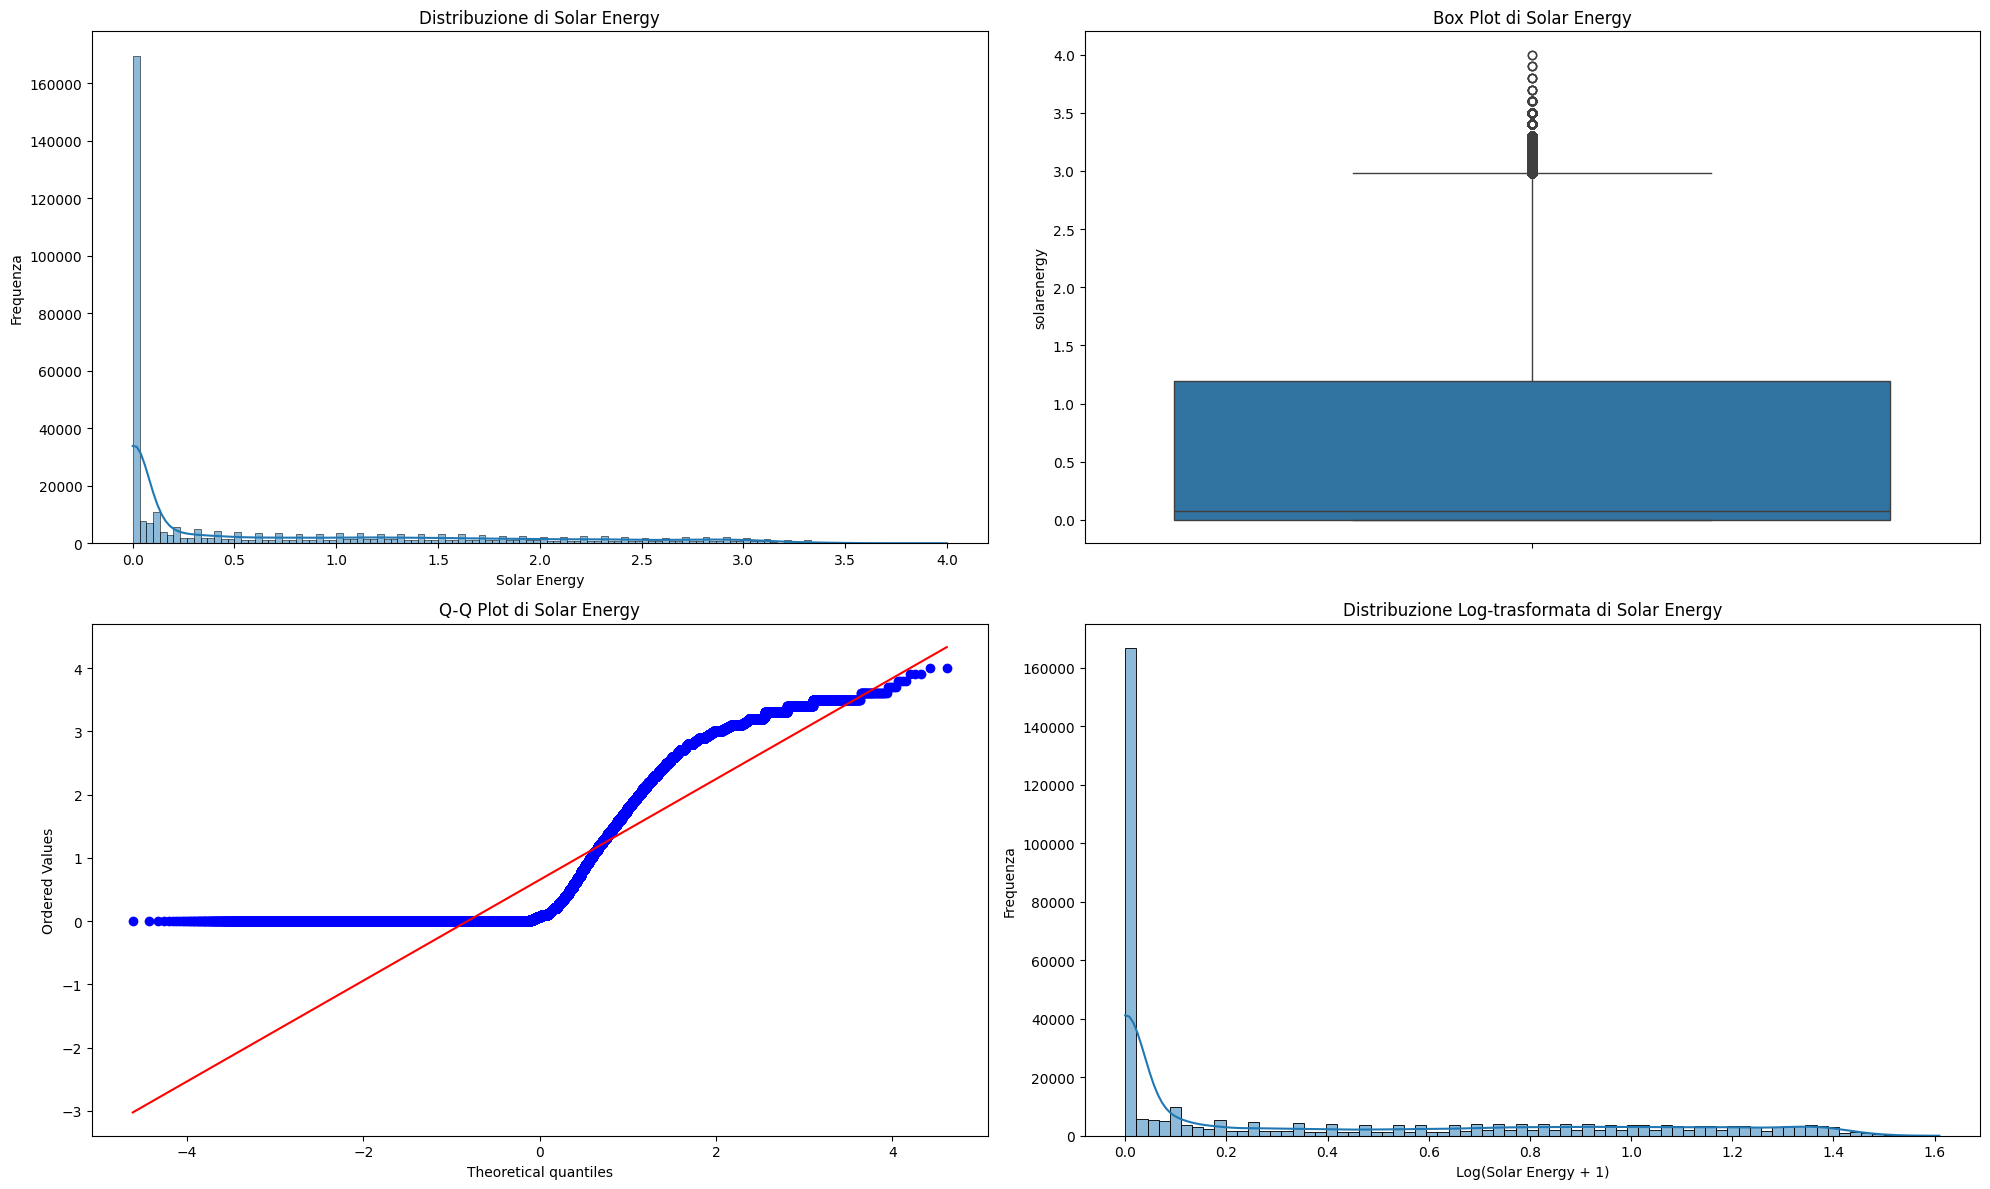

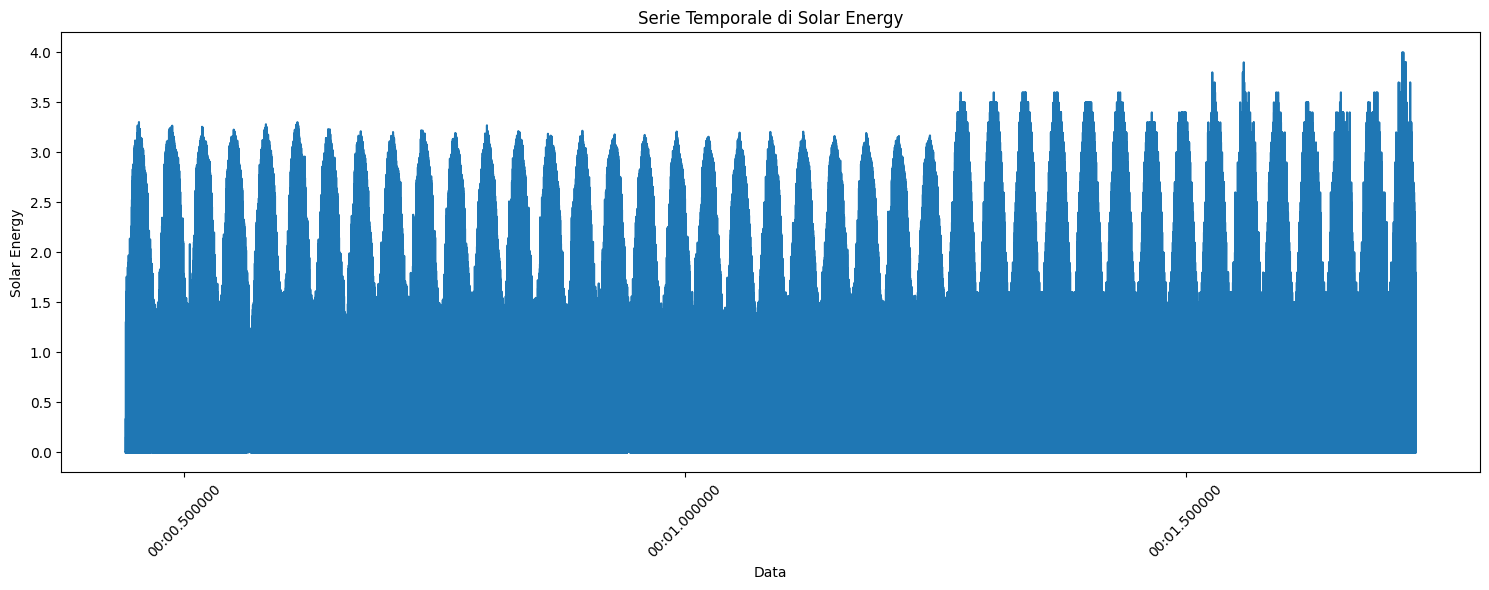

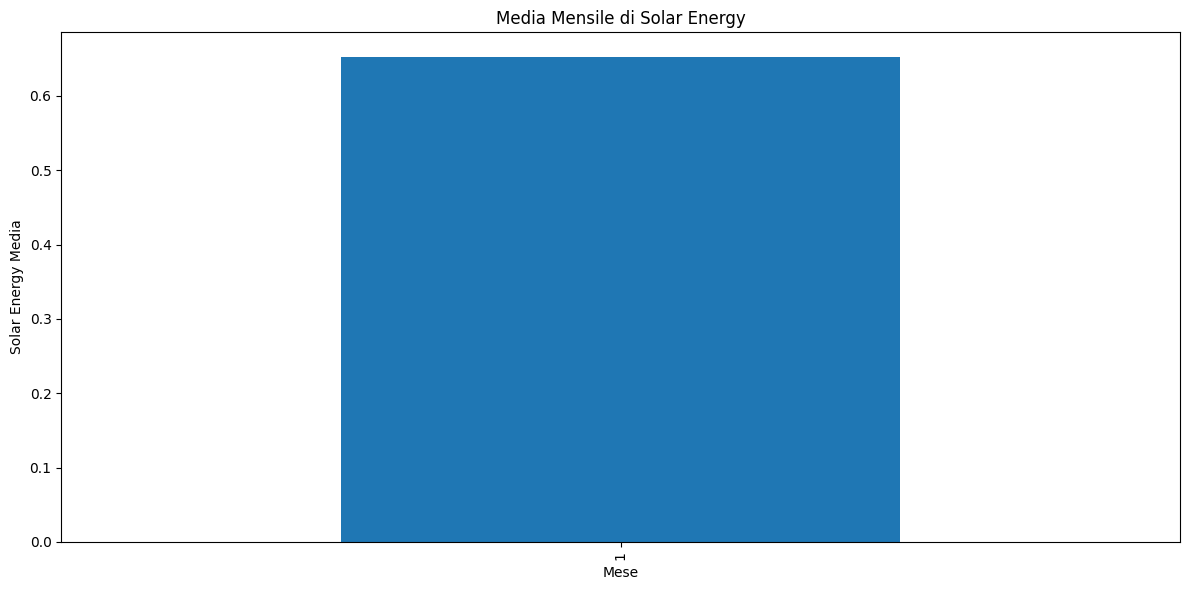


Statistiche principali di Solar Energy:
--------------------------------------------------
count          : 357,679.0000
missing        : 64.0000
zeros          : 161,156.0000
mean           : 0.6529
median         : 0.0736
std            : 0.9288
min            : 0.0000
max            : 4.0000
skewness       : 1.2834
kurtosis       : 0.3742
percentile_1   : 0.0000
percentile_5   : 0.0000
percentile_10  : 0.0000
percentile_25  : 0.0000
percentile_50  : 0.0736
percentile_75  : 1.1913
percentile_90  : 2.2530
percentile_95  : 2.7314
percentile_99  : 3.1348

Suggerimenti per la normalizzazione:
--------------------------------------------------
- La distribuzione è fortemente asimmetrica (skewness > 1)
- Considerare una trasformazione logaritmica: np.log1p(x)
- Alta presenza di zeri (45.06%)
- Considerare un modello in due parti: classificazione degli zeri + regressione sui valori non-zero


{'count': 357679,
 'missing': 64,
 'zeros': 161156,
 'mean': 0.6529324282684227,
 'median': 0.07359524816274643,
 'std': 0.928826011992019,
 'min': 0.0,
 'max': 4.0,
 'skewness': 1.2833967112068252,
 'kurtosis': 0.37419692300276486,
 'percentile_1': 0.0,
 'percentile_5': 0.0,
 'percentile_10': 0.0,
 'percentile_25': 0.0,
 'percentile_50': 0.07359524816274643,
 'percentile_75': 1.191302478313446,
 'percentile_90': 2.2529743671417237,
 'percentile_95': 2.7313732862472535,
 'percentile_99': 3.134775576591491}

In [23]:
analyze_distribution(df_updated, 'solarenergy', 'Solar Energy')


Plot saved as: 2024-11-27_23-17_error_analysis.png


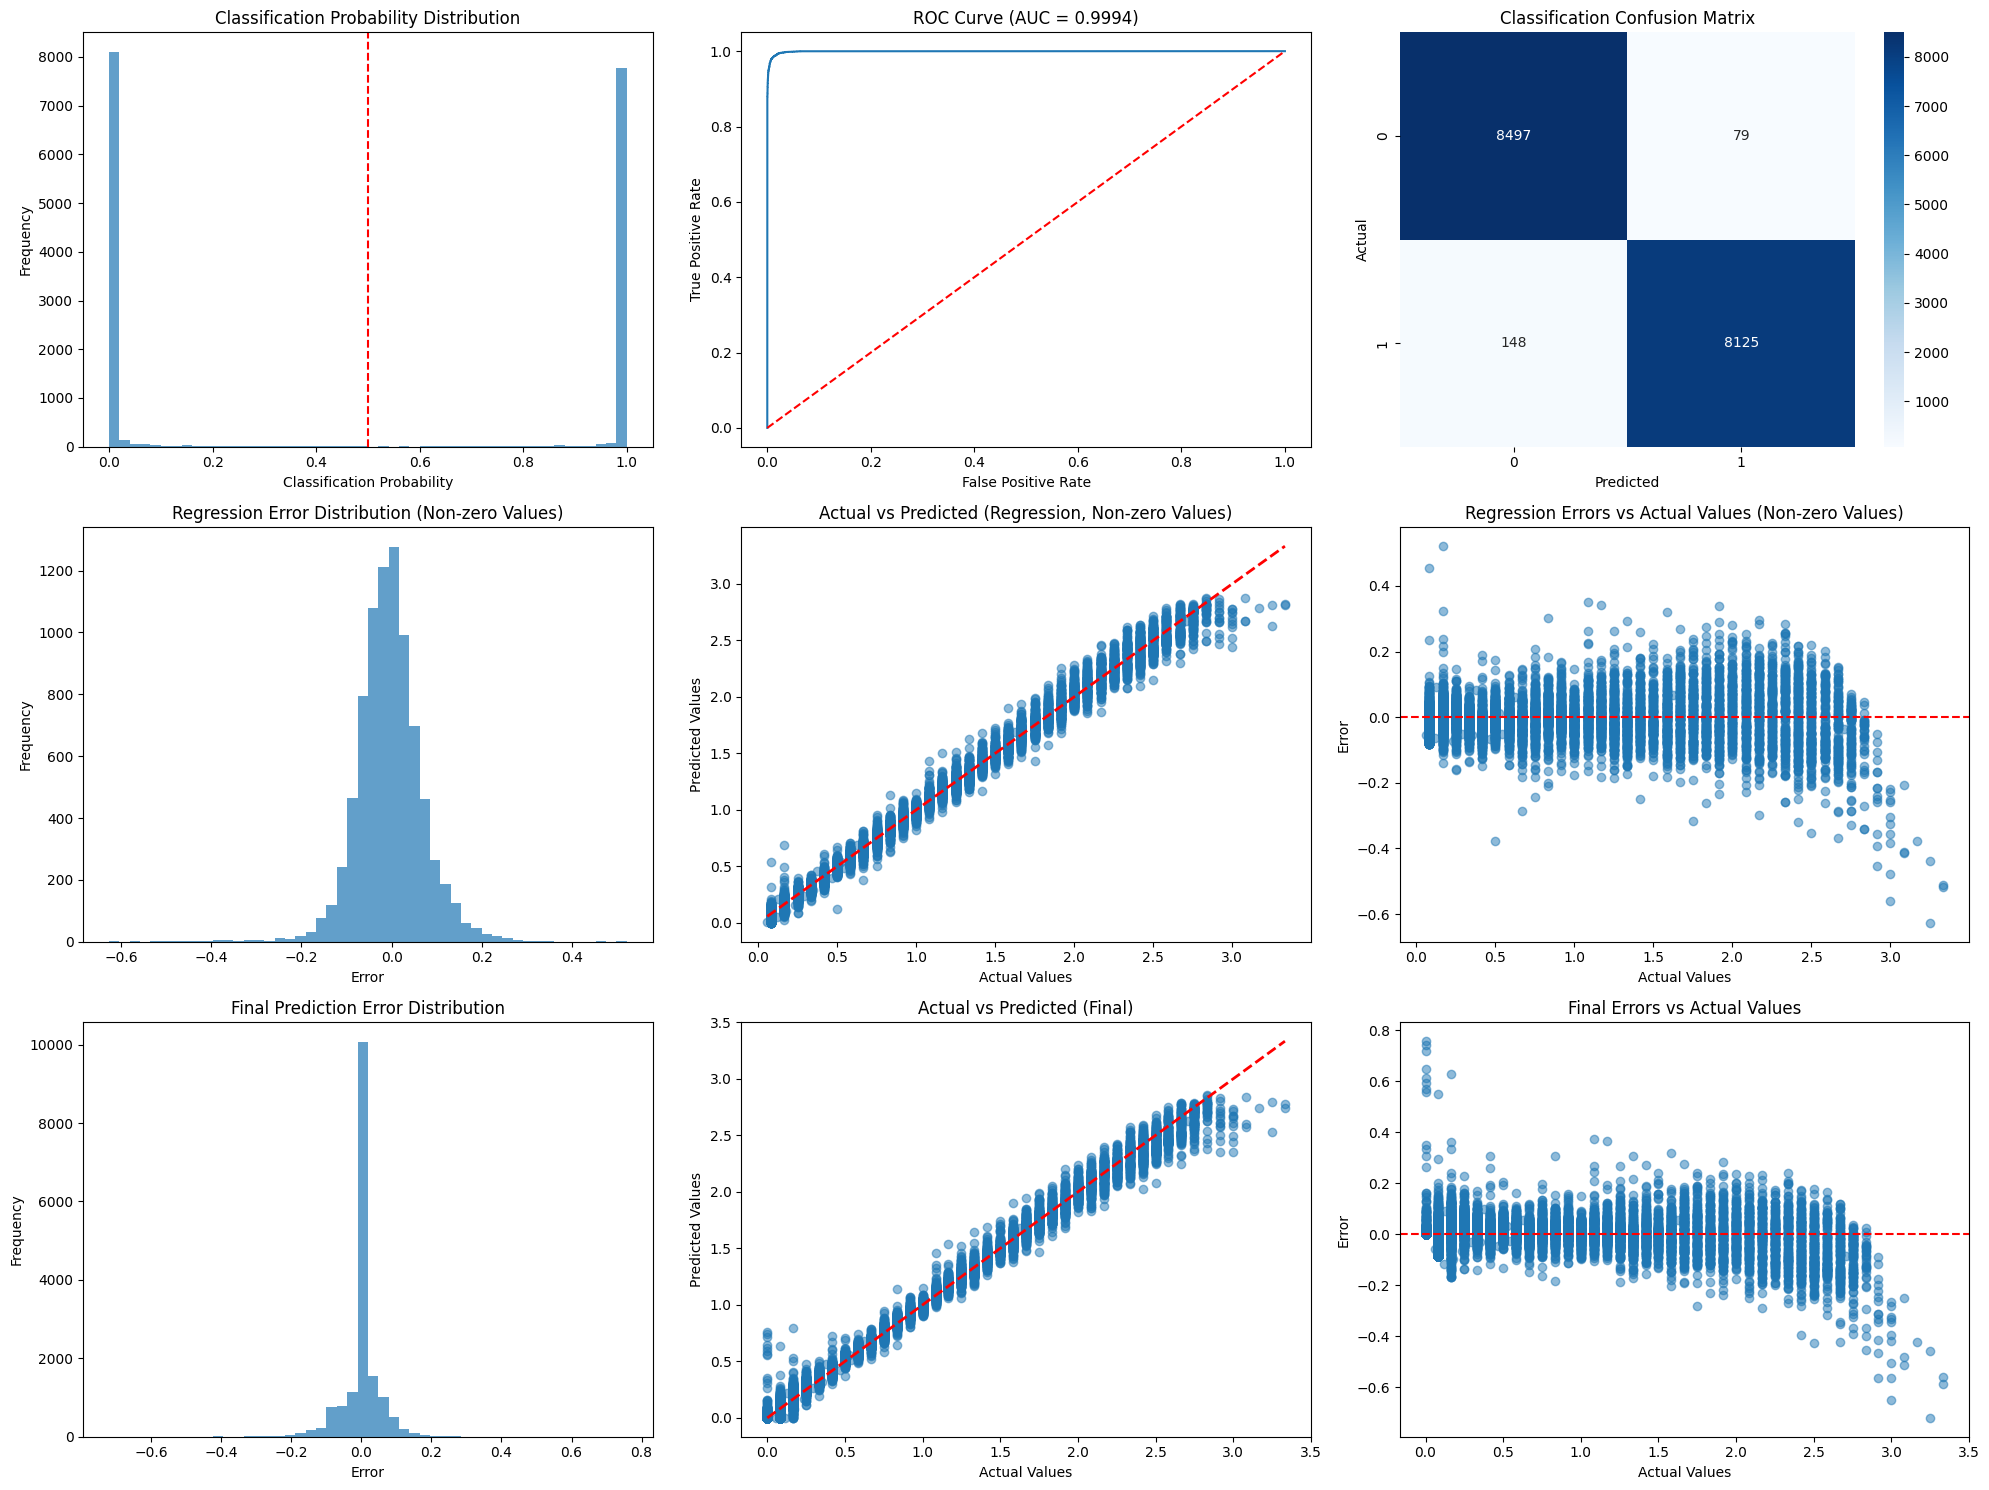


Classification Statistics:
              precision    recall  f1-score   support

         0.0       0.98      0.99      0.99      8576
         1.0       0.99      0.98      0.99      8273

    accuracy                           0.99     16849
   macro avg       0.99      0.99      0.99     16849
weighted avg       0.99      0.99      0.99     16849

AUC-ROC: 0.9994

Regression Statistics (Non-zero values):
MAE: 0.0533
RMSE: 0.0728
Mean error: -0.0042
Error std: 0.0727

Final Prediction Statistics:
MAE: 0.0282
RMSE: 0.0563
Mean error: -0.0004
Error std: 0.0563

Error Thresholds (Final Predictions):
Predictions within ±0.5: 99.9%
Predictions within ±1.0: 100.0%
Predictions within ±1.5: 100.0%
Predictions within ±2.0: 100.0%


In [25]:
def plot_error_analysis(y_true, predictions, folder_name=None):
    """
    Function to visualize prediction error analysis for the hybrid model

    Parameters:
    -----------
    y_true : array-like
        Actual values
    predictions : tuple
        Tuple containing (classification_pred, regression_pred, final_pred)
    folder_name : str, optional
        Directory to save plots. If None, plots are only displayed

    Generates:
    ----------
    - Classification analysis plots
    - Regression error analysis plots
    - Final prediction error analysis plots
    """
    from sklearn.metrics import roc_curve

    # Unpack predictions
    classification_pred, regression_pred, final_pred = predictions

    # Convert to 1D numpy arrays if needed
    y_true = np.ravel(y_true)
    classification_pred = np.ravel(classification_pred)
    regression_pred = np.ravel(regression_pred)
    final_pred = np.ravel(final_pred)

    # Create binary ground truth
    y_true_binary = (y_true > 0).astype(float)

    # Calculate errors for regression and final predictions
    regression_errors = regression_pred - y_true
    final_errors = final_pred - y_true

    # Create main figure
    plt.figure(figsize=(20, 15))

    # Classification Analysis (Top Row)
    # Plot 1: Classification Distribution
    plt.subplot(3, 3, 1)
    plt.hist(classification_pred, bins=50, alpha=0.7)
    plt.axvline(x=0.5, color='r', linestyle='--')
    plt.title('Classification Probability Distribution')
    plt.xlabel('Classification Probability')
    plt.ylabel('Frequency')

    # Plot 2: ROC Curve
    plt.subplot(3, 3, 2)
    fpr, tpr, _ = roc_curve(y_true_binary, classification_pred)
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], 'r--')
    plt.title(f'ROC Curve (AUC = {roc_auc_score(y_true_binary, classification_pred):.4f})')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

    # Plot 3: Classification Confusion Matrix
    plt.subplot(3, 3, 3)
    cm = confusion_matrix(y_true_binary, classification_pred > 0.5)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Classification Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

    # Regression Analysis (Middle Row)
    # Plot 4: Regression Error Distribution
    plt.subplot(3, 3, 4)
    plt.hist(regression_errors[y_true > 0], bins=50, alpha=0.7)
    plt.title('Regression Error Distribution (Non-zero Values)')
    plt.xlabel('Error')
    plt.ylabel('Frequency')

    # Plot 5: Actual vs Predicted (Regression)
    plt.subplot(3, 3, 5)
    mask_nonzero = y_true > 0
    plt.scatter(y_true[mask_nonzero], regression_pred[mask_nonzero], alpha=0.5)
    plt.plot([y_true[mask_nonzero].min(), y_true[mask_nonzero].max()],
             [y_true[mask_nonzero].min(), y_true[mask_nonzero].max()], 'r--', lw=2)
    plt.title('Actual vs Predicted (Regression, Non-zero Values)')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')

    # Plot 6: Regression Errors vs Actual Values
    plt.subplot(3, 3, 6)
    plt.scatter(y_true[mask_nonzero], regression_errors[mask_nonzero], alpha=0.5)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.title('Regression Errors vs Actual Values (Non-zero Values)')
    plt.xlabel('Actual Values')
    plt.ylabel('Error')

    # Final Predictions Analysis (Bottom Row)
    # Plot 7: Final Error Distribution
    plt.subplot(3, 3, 7)
    plt.hist(final_errors, bins=50, alpha=0.7)
    plt.title('Final Prediction Error Distribution')
    plt.xlabel('Error')
    plt.ylabel('Frequency')

    # Plot 8: Actual vs Predicted (Final)
    plt.subplot(3, 3, 8)
    plt.scatter(y_true, final_pred, alpha=0.5)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
    plt.title('Actual vs Predicted (Final)')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')

    # Plot 9: Final Errors vs Actual Values
    plt.subplot(3, 3, 9)
    plt.scatter(y_true, final_errors, alpha=0.5)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.title('Final Errors vs Actual Values')
    plt.xlabel('Actual Values')
    plt.ylabel('Error')

    plt.tight_layout()

    # Save plot if directory is specified
    if folder_name is not None:
        try:
            filename = f'{folder_name}_error_analysis.png'
            plt.savefig(filename, dpi=300, bbox_inches='tight')
            print(f"\nPlot saved as: {filename}")
        except Exception as e:
            print(f"\nError saving plot: {str(e)}")

    plt.show()

    # Print comprehensive statistics
    print("\nClassification Statistics:")
    print(classification_report(y_true_binary, classification_pred > 0.5))
    print(f"AUC-ROC: {roc_auc_score(y_true_binary, classification_pred):.4f}")

    print("\nRegression Statistics (Non-zero values):")
    mask_nonzero = y_true > 0
    if np.any(mask_nonzero):
        print(f"MAE: {np.mean(np.abs(regression_errors[mask_nonzero])):.4f}")
        print(f"RMSE: {np.sqrt(np.mean(regression_errors[mask_nonzero] ** 2)):.4f}")
        print(f"Mean error: {np.mean(regression_errors[mask_nonzero]):.4f}")
        print(f"Error std: {np.std(regression_errors[mask_nonzero]):.4f}")

    print("\nFinal Prediction Statistics:")
    print(f"MAE: {np.mean(np.abs(final_errors)):.4f}")
    print(f"RMSE: {np.sqrt(np.mean(final_errors ** 2)):.4f}")
    print(f"Mean error: {np.mean(final_errors):.4f}")
    print(f"Error std: {np.std(final_errors):.4f}")

    # Calculate percentage of errors within thresholds
    thresholds = [0.5, 1.0, 1.5, 2.0]
    print("\nError Thresholds (Final Predictions):")
    for threshold in thresholds:
        within_threshold = np.mean(np.abs(final_errors) <= threshold) * 100
        print(f"Predictions within ±{threshold}: {within_threshold:.1f}%")

# Example usage
plot_error_analysis(y_test, predictions, folder_name=folder_name)